In [1]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

%mkdir tmp/
#download preprocessed data from deeplearning.ai
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O tmp/bbc-text.csv

--2020-04-29 06:27:33--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘tmp/bbc-text.csv’

tmp/bbc-text.csv    100%[===================>]   4.82M  --.-KB/s    in 0.04s   

2020-04-29 06:27:33 (127 MB/s) - ‘tmp/bbc-text.csv’ saved [5057493/5057493]



##Set some parameters

In [0]:
vocab_size = 1000 #1000, 3000
embedding_dim = 16 #16, 32
max_length = 120 #120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

##Set stopwords and remove them from the sentences

In [3]:
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))
# Expected Output
# 153

153


In [4]:
with open("tmp/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        sentence = row[1]
        for word in stopwords:
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
        sentences.append(sentence)

print("total labels:", len(labels))
print("total sentences:", len(sentences))
print("one example:", sentences[0])
# Expected Output
# 2225
# 2225
# tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us s tivo uk s sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take off europe lack high-definition programming. not can people forward wind adverts  can also forget abiding network channel schedules  putting together a-la-carte entertainment. us networks cable satellite companies worried means terms advertising revenues well  brand identity  viewer loyalty channels. although us leads technology moment  also concern raised europe  particularly growing uptake services like sky+.  happens today  will see nine months years  time uk   adam hume  bbc broadcast s futurologist told bbc news website. likes bbc  no issues lost advertising revenue yet. pressing issue moment commercial uk broadcasters  brand loyalty important everyone.  will talking content brands rather network brands   said tim hanlon  brand communications firm starcom mediavest.  reality broadband connections  anybody can producer content.  added:  challenge now hard promote programme much choice.   means  said stacey jolna  senior vice president tv guide tv group  way people find content want watch simplified tv viewers. means networks  us terms  channels take leaf google s book search engine future  instead scheduler help people find want watch. kind channel model might work younger ipod generation used taking control gadgets play them. might not suit everyone  panel recognised. older generations comfortable familiar schedules channel brands know getting. perhaps not want much choice put hands  mr hanlon suggested.  end  kids just diapers pushing buttons already - everything possible available   said mr hanlon.  ultimately  consumer will tell market want.   50 000 new gadgets technologies showcased ces  many enhancing tv-watching experience. high-definition tv sets everywhere many new models lcd (liquid crystal display) tvs launched dvr capability built  instead external boxes. one example launched show humax s 26-inch lcd tv 80-hour tivo dvr dvd recorder. one us s biggest satellite tv companies  directtv  even launched branded dvr show 100-hours recording capability  instant replay  search function. set can pause rewind tv 90 hours. microsoft chief bill gates announced pre-show keynote speech partnership tivo  called tivotogo  means people can play recorded programmes windows pcs mobile devices. reflect increasing trend freeing multimedia people can watch want  want.

total labels: 2225
total sentences: 2225
one example: tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us s tivo uk s sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take off europe lack high-definition programming. not can people forward wind adverts  can also forget abiding network channel sch

##Seperate data into training and validation sets

In [5]:
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

# Expected output (if training_portion=.8)
# 1780
# 1780
# 1780
# 445
# 445

1780
1780
1780
445
445


##Tokenize and pad the sentences

In [6]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

print("lenth before padding:", len(train_sequences[0]))
print("lenth after padding:", len(train_padded[0]))

print("lenth before padding:", len(train_sequences[1]))
print("lenth after padding:", len(train_padded[1]))

print("lenth before padding:", len(train_sequences[10]))
print("lenth after padding:", len(train_padded[10]))

# Expected Ouput
# 449
# 120
# 200
# 120
# 192
# 120

lenth before padding: 449
lenth after padding: 120
lenth before padding: 200
lenth after padding: 120
lenth before padding: 192
lenth after padding: 120


In [7]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

print(len(validation_sequences))
print(validation_padded.shape)

# Expected output
# 445
# (445, 120)

445
(445, 120)


##Tokenize and pad the labels

In [8]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)
label_index = label_tokenizer.word_index

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

# Expected output
# [4]
# [2]
# [1]
# (1780, 1)
# [5]
# [4]
# [3]
# (445, 1)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


In [9]:
print(label_index)
labeldic = {v:k for k,v in label_index.items()}
print(labeldic)

{'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}
{1: 'sport', 2: 'business', 3: 'politics', 4: 'tech', 5: 'entertainment'}


##Build your model

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)), #16, 32
    tf.keras.layers.Dense(16, activation='relu'), #16, 32
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 102       
Total params: 20,854
Trainable params: 20,854
Non-trainable params: 0
_________________________________________________________________


## stop when the training is good enough

In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>0.95):
      print("\n val_acc is high so cancelling training!")
      self.model.stop_training = True

In [16]:
callbacks = myCallback()
num_epochs = 40
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2, callbacks=[callbacks])

Epoch 1/40
56/56 - 1s - loss: 1.7450 - acc: 0.2281 - val_loss: 1.6646 - val_acc: 0.3820
Epoch 2/40
56/56 - 1s - loss: 1.5515 - acc: 0.3596 - val_loss: 1.3495 - val_acc: 0.4337
Epoch 3/40
56/56 - 1s - loss: 1.1351 - acc: 0.4663 - val_loss: 0.9700 - val_acc: 0.5955
Epoch 4/40
56/56 - 1s - loss: 0.8412 - acc: 0.6708 - val_loss: 0.7973 - val_acc: 0.7348
Epoch 5/40
56/56 - 1s - loss: 0.7192 - acc: 0.7404 - val_loss: 0.7934 - val_acc: 0.7843
Epoch 6/40
56/56 - 1s - loss: 0.5908 - acc: 0.8202 - val_loss: 0.5703 - val_acc: 0.7663
Epoch 7/40
56/56 - 1s - loss: 0.4853 - acc: 0.8275 - val_loss: 0.5146 - val_acc: 0.7888
Epoch 8/40
56/56 - 1s - loss: 0.3793 - acc: 0.8579 - val_loss: 0.5311 - val_acc: 0.8337
Epoch 9/40
56/56 - 1s - loss: 0.3566 - acc: 0.8753 - val_loss: 0.5129 - val_acc: 0.8202
Epoch 10/40
56/56 - 1s - loss: 0.2345 - acc: 0.9382 - val_loss: 0.4512 - val_acc: 0.8719
Epoch 11/40
56/56 - 1s - loss: 0.1570 - acc: 0.9629 - val_loss: 0.4547 - val_acc: 0.8854
Epoch 12/40
56/56 - 1s - loss:

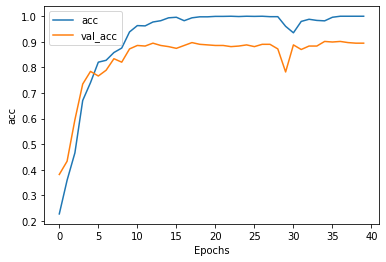

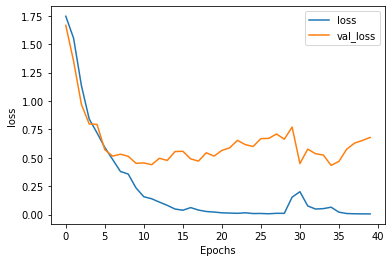

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [0]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [19]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

# Expected output
# (1000, 16)

(1000, 16)


## test the model

In [20]:
sentences = ["finnan says irish can win group steve finnan believes the republic of ireland can qualify directly for the world cup finals.  after saturday s superb display in the draw in paris  ireland face minnows the faroe islands in dublin on wednesday. the "]
test_sequences = tokenizer.texts_to_sequences(sentences)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

print(test_padded)
r = model.predict(test_padded)
for u, v in list(zip(sentences, r)):
    print(f'{u}')
    print('→', labeldic[list(v).index(max(list(v)))])

[[  1  53 706  13  64  98   1   1 626   1   1   1 185  13   1   1   1   1
   20 258   1   1 467   2   1   1 614   1   1 614   1 185 304   1   1   1
    1 614   1 592 431   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]]
finnan says irish can win group steve finnan believes the republic of ireland can qualify directly for the world cup finals.  after saturday s superb display in the draw in paris  ireland face minnows the faroe islands in dublin on wednesday. the 
→ business
